In [213]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from scipy.interpolate import UnivariateSpline

In [234]:
data = pd.read_csv('test_data.csv')
x = data.loc[:, ('X1', 'X2')].to_numpy()
x = x[0:100, ]
x = x - np.mean(x, 0)
index = np.arange(0, len(x))

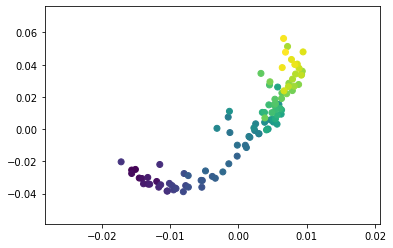

In [235]:
pca = PCA(n_components = 2)
pca.fit(x)
pc1 = pca.components_[:, 0]
plt.scatter(x[:, 0], x[:, 1], c = index)

In [236]:
def abline(a, b):
    plt.plot([a[0], b[0]], [a[1], b[1]], color = 'b', alpha = 0.25)

def proj(a, x):
    # projection of data onto direction a
    return np.kron(np.dot(x, a)/np.dot(a, a), a).reshape(x.shape)

def renorm_parameterisation(p):
    seg_lens = [np.linalg.norm(p[i, :] - p[i+1, :]) for i in range(0, p.shape[0]-1)]
    s = np.zeros(p.shape[0])
    s[1:] = np.cumsum(seg_lens)
    s = s/sum(seg_lens)
    return s

def proj_to_segment(x, a, b):
    z = proj(b-a, x-a) 
    z[(z/(b-a))[0] > 1] = b-a
    z[(z/(b-a))[0] < 0] = np.zeros(a.shape)
    return z+a

def dist_to_segment(x, a, b):
    return min([np.linalg.norm(x-a), np.linalg.norm(x-b), 
               np.linalg.norm((x - proj_to_segment(x, a, b)))])

In [237]:
p = proj(pc1, x) # starting point for iteration
order = np.argsort([np.linalg.norm(p[0, :] - p[i, :]) for i in range(0, p.shape[0])])
p = p[order]

/home/zsteve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


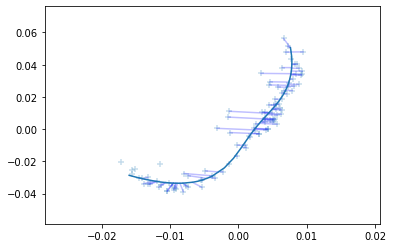

In [244]:
s = renorm_parameterisation(p)

plt.scatter(x[:, 0], x[:, 1], alpha = 0.25, marker = '+')

s_interp = np.zeros(x.shape[0])
# project to curve
# for i in range(0, x.shape[0]):
for i in range(0, x.shape[0]):
    z = x[i, :]
    val_min = np.Inf
    idx_min = 0
    for j in range(0, p.shape[0]-1):
        d = dist_to_segment(z, p[j, :], p[j+1, :])
        if d < val_min:
            val_min = d
            idx_min = j
    q = proj_to_segment(z, p[idx_min, :], p[idx_min+1, :])
    s_interp[i] = (np.linalg.norm(q - p[idx_min, :])/np.linalg.norm(p[idx_min+1, :] - p[idx_min, :]))*(s[idx_min+1]-s[idx_min]) + s[idx_min]
    abline(z, q) 
    
plt.plot(p[:, 0], p[:, 1])

In [245]:
order = np.argsort(s_interp)
s_interp = s_interp[order]
x = x[order, :]

sx = UnivariateSpline(s_interp, x[:, 0], k = 5)
sy = UnivariateSpline(s_interp, x[:, 1], k = 5)

spline_x = sx(s_interp)
spline_y = sy(s_interp)
p[:, 0] = spline_x
p[:, 1] = spline_y
s = s_interp

plt.scatter(x[:, 0], x[:, 1], alpha = 0.25, marker = '+')
plt.plot(spline_x, spline_y)


/home/zsteve/anaconda3/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:178: RuntimeWarning: invalid value encountered in greater_equal
  if not np.all(diff(x) >= 0.0):


ValueError: x must be increasing if s > 0